In [2]:
from skimage import data, color, transform, io, filters, morphology
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Operacje punktowe

Najpierw wczytaj jakiś przykładowy obraz w odcieniach szarości i wyświetl. Jaki zakres wartości posiada ten obraz?

float64
(300, 451)
0.755610980392
0.0151207843137


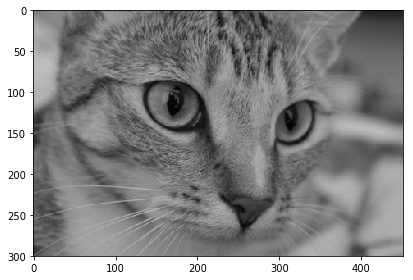

In [3]:
i = color.rgb2gray(data.chelsea())

io.imshow(i)

print(i.dtype)
print(i.shape)
print(i.max())
print(i.min())

Zdefiniuj funkcję $f(x)$, która zwraca $x$ powiększoną o jakąś stałą wartość (np. $0.5$). Pamiętaj że obraz musi zaweriać liczby w zakresie $<0,1>$, więc zastosuj funkcję *numpy.clip* aby wymusić tą zależność. Żeby łatwo zastosować funkcję na wszystkich pikselach obrazu, możesz użyć metody *numpy.vectorize* aby przekształcić standardową funkcję, na taką, która może być stosowana na wektorach numpy.

Na końcu, zastosuj funkcję na poprzednim obrazie i wyświetl wynik.

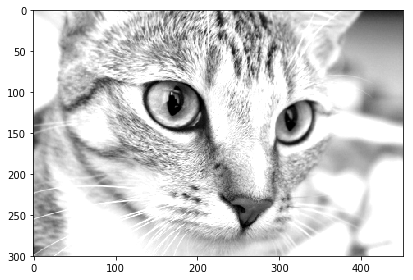

In [4]:
def f(x):
    y = 2*x - 0.1
    return clip(y, 0, 1)

f = vectorize(f)

j = f(i)

io.imshow(j)

Zdefiniuj prostą funkcję liniową $f(x)=a*x+b$ jako operację punktową obrazu. Żeby łatwiej zrozumieć działanie tej funkcji na obrazie, oprócz stosowania jej na obrazie, narysuj wykres liniowy (*pyploy.plot*) pokazujący jak ta funkcja zmienia wsyzstkie odcienie szarości (w zakresie $<0,1>$).

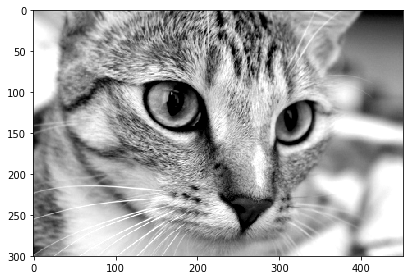

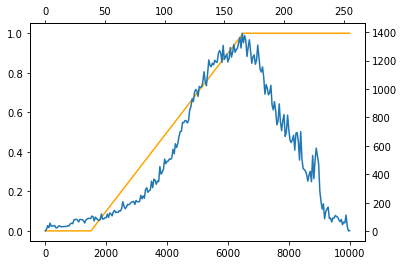

In [5]:
def f(x, a, b):
    y = a * x + b
    return clip(y, 0, 1)
f = vectorize(f)

h, _ = histogram(i, bins = 256)

a = 2
b = -0.3
j = f(i, a, b)

io.imshow(j)
figure()
x = arange(0, 1, 0.0001)
plot(f(x, a, b), "orange")
twinx()
twiny()
plot(h)

Powyższe przekształcenia służą przeważnie do zmiany ekspozycji. Jeśli zrejestrowany obraz jest prześwietlony (overexposed) albo niedoświetlony (underexposed), histogram takiego obrazu będzie skupiony w pewnym wąskim obszarze odcieni szarości. Stosowanie powyższej funkcji liniowej pozwoli wydobić z histogramu istotne wartości odcieni szarości (te zawierające informacje) i odrzucenie innych.

Znajdź jakiś przykładowy obraz wymagający korekty ekspozycji i znajdź odpowiednie parametry dla powyższej operacji.

Na przykład:
https://lifeaperture.files.wordpress.com/2011/04/dsc0085.jpg

UWAGA: Żeby przyspieszyć działanie algorytmu, można zastosować *transform.rescale* żeby zmniejszyć rozmiar obrazu.

In [6]:
!wget https://lifeaperture.files.wordpress.com/2011/04/dsc0085.jpg

--2017-12-11 14:18:15--  https://lifeaperture.files.wordpress.com/2011/04/dsc0085.jpg
Resolving lifeaperture.files.wordpress.com (lifeaperture.files.wordpress.com)... 192.0.72.16, 192.0.72.17
Connecting to lifeaperture.files.wordpress.com (lifeaperture.files.wordpress.com)|192.0.72.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5151649 (4.9M) [image/jpeg]
Saving to: ‘dsc0085.jpg.1’

dsc0085.jpg.1       100%[=====================>]   4.91M  25.6MB/s   in 0.2s   

2017-12-11 14:18:15 (25.6 MB/s) - ‘dsc0085.jpg.1’ saved [5151649/5151649]



/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


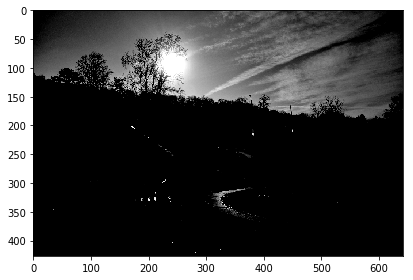

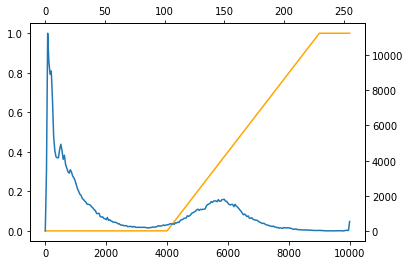

In [7]:
i = io.imread("dsc0085.jpg")
i = color.rgb2grey(i)

i = transform.rescale(i, 0.15)

io.imshow(i)

h, _ = histogram(i, bins = 256)

a = 2
b = -0.8
j = f(i, a, b)

io.imshow(j)
figure()
x = arange(0, 1, 0.0001)
plot(f(x, a, b), "orange")
twinx()
twiny()
plot(h)

Powyższa operacja skutecznie rozjaśnia (albo ściemnia) interesujące nas odcienie, ale inne są całkowicie usuwane z obrazu. W przypadku rozjaśniania, część obrazu zostanie zmieniona na całkowicie biały kolor, a w przypadku ściemniania na czarny. Powoduje to utratę szczegółów w niektórych (możliwie dużych) fragmentach obrazu.

Zamiast calkowicie usunąć wybrany fragment obrazu, lepiej by było zastosować nieliniową operację, która "rozciąga" interesujące nas fragmenty histogramu, "ściska" te mniej interesujące, ale nadal nie powoduje ich całkowitą utratę. Jednym z takich nieliniowych operacji jest tzw. **gamma**. Definiujemy ją jako:

\begin{equation}
f(x)=x^\gamma
\end{equation}

Stwórz własny operator gamma i znajdź odpowiednie parametry dla swojego obrazu.

/usr/local/lib/python3.4/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


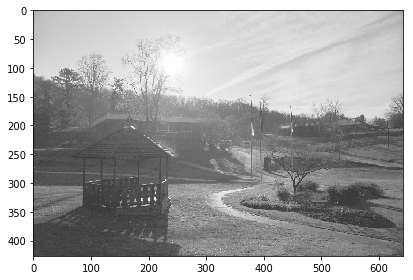

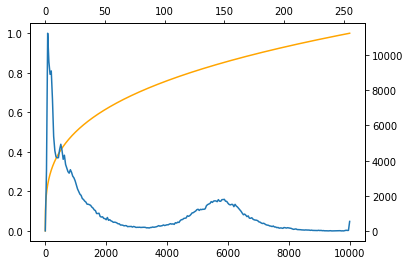

In [8]:
i = io.imread("dsc0085.jpg")
i = color.rgb2grey(i)

def f(x, g):
    y = x ** g
    return clip(y, 0, 1)
f = vectorize(f)

i = transform.rescale(i, 0.15)

io.imshow(i)

h, _ = histogram(i, bins = 256)

g = 0.3
j = f(i, g)

io.imshow(j)
figure()
x = arange(0, 1, 0.0001)
plot(f(x, g), "orange")
twinx()
twiny()
plot(h)

Zaimplementuj opearcję wyrównania histogramu. Należy najpierw policzyć histogram obrazu, a potem policzyć jego *dystrybuantę*, czyli skumulowaną sumę poszczególnych próbek histogramu. Do tego celu można użyc funkcję *numpy.cumsum*. Jeśli dystrybuantę potraktujemy jako funkcję do operatora punktowego, wynik takiej operacji powinien być "wyrównany".

Zastosuj taką operację na swoim obrazie.

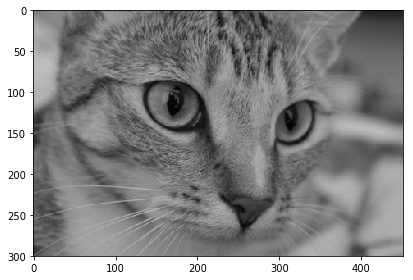

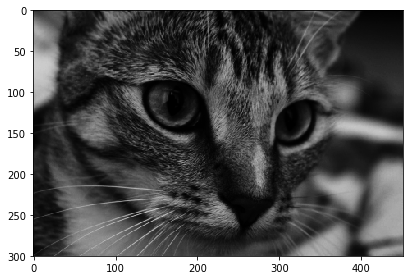

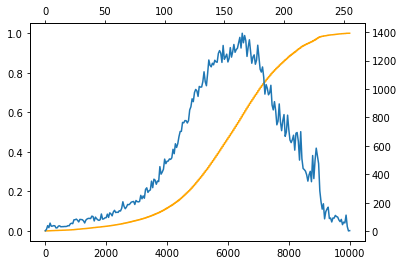

In [9]:
i = io.imread("dsc0085.jpg")
i = data.chelsea()
i = color.rgb2grey(i)

h, _ = histogram(i, bins = 256)

c = cumsum(h)
c = c/c.max()

def f(x):
    y = c[int(x*255)]
    return clip(y, 0, 1)
f = vectorize(f)

# i = transform.rescale(i, 0.15)

g = 0.3
j = f(i)
io.imshow(i)
figure()
io.imshow(j)
figure()
x = arange(0, 1, 0.0001)
plot(f(x), "orange")
twinx()
twiny()
plot(h)

# Binaryzacja obrazu

Najprostsza metoda binaryzacji jest tzw. progowanie (ang. thresholding). Dla zdefiniowanej wartości progu (np. 0.5), każdy piksel którego wartość przekracza ten próg ustaw na 1, a wszystkie inne na 0. Użyj zdjęcia *camera* (z klasy *skimage.data*) do wszystkich zadań.

/usr/local/lib/python3.4/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


<module 'skimage.filters' from '/usr/local/lib/python3.4/dist-packages/skimage/filters/__init__.py'>

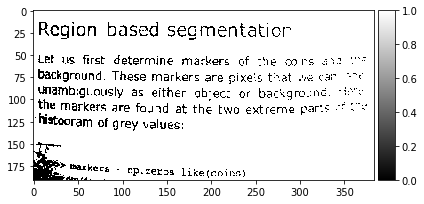

In [10]:
i = data.page()

th = 80

i[i < th] = 0
i[i > 0] = 1

io.imshow(i, cmap=cm.gray)

filters

Dla większości zdjęć, proste progowanie nie jest skuteczną metodą detekcji elementów morfologicznych. Jest kilka rozszerzeń jakie można zastosować: użyć kilka progów (czyli np. "od-do"), zmienić przestrzeń barw (np. progowanie na podstawie odcieni barw), wykonać inne kroki przetwarzania wstępnego (np. wygładzanie, odszumianie, normalizacja).

## Binaryzacja kontekstowa - metoda Otsu

Dla niektórych zdjęć trudno wyliczyć uniwersalny próg, bo kontrast się zmienia w zależności od obszaru zdjęcia jaki analizujemy. Sprawdź zdjęcie z metody *data.page* i zastosuj na nim jakiś próg.

Metoda wymyślona przez naukowaca Nobuyuki Otsu polega na wyliczeniu optymalnego progu dla każdego piksela (na podstawie jego najbliższego sąsiedztwa) i dokonanie binaryzacji na tej podstawie. Do znalezienia progu użyj metody *skimage.filters.rank.otsu*, a jako element strukturalny tej metody użyj objekt *skimage.morphology.disk*. Odejmij wartość 10 od wyliczonego progu żeby się pozbyć artefaktów w tle.

/usr/local/lib/python3.4/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


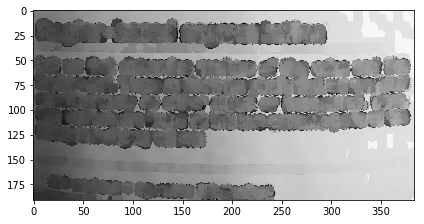

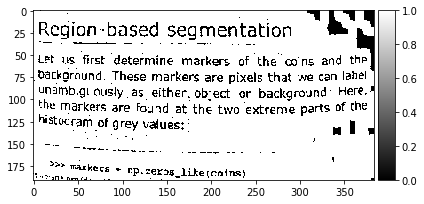

In [11]:
i = data.page()

t = filters.rank.otsu(i, selem = morphology.disk(5))

t -= 10
i[i < t] = 0
i[i > 0] = 1

io.imshow(t, cmap=cm.gray)
figure()
io.imshow(i, cmap=cm.gray)

Podobne efekty można uzyskać stosując inne lokalnie adaptacyjnie metody. Użyj metody *skimage.filters.threshold_local* o sąsiedztwie 35 i parametrze *offset* równym 10 na tym samym obrazie. Sprawdź inne opcje jakie ma ta metoda.

/usr/local/lib/python3.4/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/usr/local/lib/python3.4/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


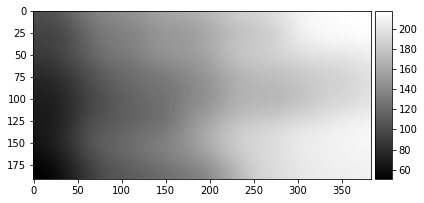

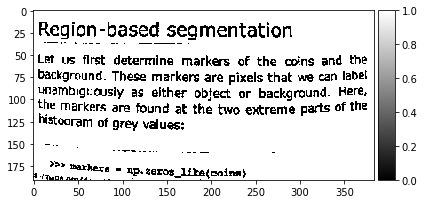

In [12]:
i = data.page()

t = filters.threshold_local(i, block_size=101, offset = 10)

t -= 10
i[i < t] = 0
i[i > 0] = 1

io.imshow(t, cmap=cm.gray)
figure()
io.imshow(i, cmap=cm.gray)

# Praca domowa

Zamiplementuj metodę tranformacji kontrastu na podstawie funkcji logistycznej z parametrem $k$ określającym jej intesywność. Uważaj żeby funkcja zawsze była znormalizowana tak, żeby 0 było zamieniane na 0, a 1 na 1.

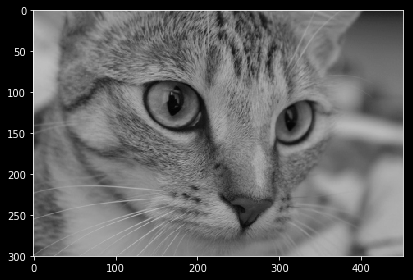

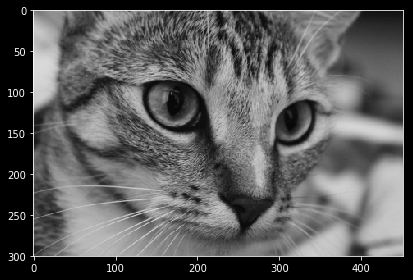

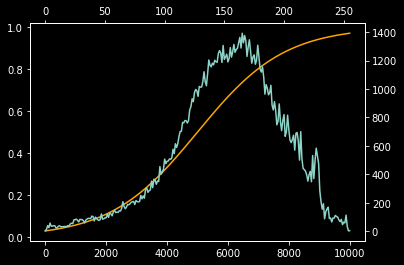

In [27]:
style.use("dark_background")

i = io.imread("dsc0085.jpg")
i = data.chelsea()
i = color.rgb2grey(i)

h, _ = histogram(i, bins = 256)

c = cumsum(h)
c = c/c.max()

def logist(x, k):
    L = 1
    x0 = 0.5
    return L / (1 + e**(-k*(x-x0)))
f = vectorize(f)

j = logist(i, 7)
io.imshow(i)
figure()
io.imshow(j)
figure()
x = arange(0, 1, 0.0001)
plot(logist(x, 7), "orange")
twinx()
twiny()
plot(h)